This notebook should take care of most preprocessing steps to ready the data for being fed into the model. It relies on the folder structure of the data as found on RDSF being maintained, and in some cases this will need tweaking as this code is not sophisticated enough to check/format all permutations of folder structures.

This code was initially authored by Hollie Hindley (hh16494) and has been refactored by Gabriel Gibb (gg17047).

This code has only been tested on Linux, and so performance on Windows may suffer issues.

Close attention has not been paid to speed/performance of the code - it works. This file should (hopefully) only need to be used once per dataset.

In [1]:
import os
import PIL
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
from pandas import DataFrame
import shutil
import re
import glob
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [2]:
CUDA_VISIBLE_DEVICES="-1"

In [3]:
# global variables
PATH = '/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/'    # where all data folders should be
ANTIBIOTIC = "kanamycin"   # this should be at the start of any folders containing eg kanamycin data

In [4]:
def convert_to_jpg(source, destination):
    """Given a source dir containing TIF files (at any level) copys dir structure to destination and populates 
    with images converted to JPG format"""
    for (root, dirs, files) in os.walk(source):
        for file in files:
            if str(file).endswith('.TIF'):
                im=Image.open(os.path.join(root, file))
                im.mode = 'I'
                file_path = os.path.join(destination, os.path.relpath(root, source))
                os.makedirs(file_path, exist_ok = True)
                im.point(lambda i:i*(1./256)).convert('L').save(os.path.join(file_path, file[:-4] +'.jpeg'))

In [5]:
def copy_centres_file(source, destination):
    """Finds the text file containing the image centres and copies it to the new jpg folder"""
    dirs = os.listdir(source)
    for dir_ in dirs:
        for file in os.listdir(os.path.join(source,dir_)):
            if str(file).endswith('.txt'):
                shutil.copyfile(os.path.join(source,dir_, file), os.path.join(destination,dir_+'.txt'))


In [6]:
def clean_video_folder_names(source):
    """Cleans the folder names from the weird namings they have in rdsf"""
    for (root, dirs, files) in os.walk(source):
        if dirs and str(dirs[0]).startswith("video"):
            for i in range(len(dirs)):
                if not "video{}".format(i) in dirs:
                    os.rename(os.path.join(root,dirs[i]),os.path.join(root,"video{}".format(i)))

In [7]:
def convert_all_folders():
    """Searches PATH for folders prefixed with ANTIBIOTIC and applies the convert_to_jpg function"""
    for (root, dirs, files) in tqdm(os.walk(PATH)):
        # search dirs in PATH for those containing relevant data to our ANTIBIOTIC
        # I think this would work better using root and not dirs 
        for dir_ in dirs:
            dir_ = str(dir_)
            # endswith condition prevents duplicating already converted folders
            if dir_.startswith(ANTIBIOTIC) and not dir_.endswith(('jpg', 'crop')):
                convert_to_jpg(PATH+dir_, PATH+dir_+'_jpg')
                copy_centres_file(PATH+dir_, PATH+dir_+'_jpg')

In [8]:
# folders must be of form eg: kanamycin_videos/treated_susceptible/ and then the video folders
convert_all_folders()

0it [00:00, ?it/s]

In [9]:
clean_video_folder_names(PATH+'kanamycin_videos_jpg')

In [10]:
def centre(filepath):
    """Function which pulls the centre coordinates for the current video being cropped"""
    
    dirname = os.path.dirname(filepath)
    file_number = number_from_filename(dirname)
    [parent, subfolder] = os.path.split(os.path.split(dirname)[0])
    df = pd.read_csv(os.path.join(PATH, parent, subfolder+'.txt'), delimiter='\t+')
    
    # this is where it gets messy - if the centres file stops early we get an index error
    # I'm not sure there's a better way of handling than just using the default [150,150]
    # centre in this case. This didnt seem to cause an issue later
    while True:
        try:
            centre = df.values[file_number][:2]
            break
        except IndexError:
            centre = [150, 150]
            break
    return centre

In [11]:
def number_from_filename(folder):
    name = os.path.basename(folder)
    split = re.split(r'[a-zA-Z]+', name)
    number = int(split[1])
    return number

In [12]:
def centring_centres(bac_centre, im, h, x1, x2): 
    """Crops the image according to a centre supplied by the 'centre' function"""
    y = bac_centre[1]
    shave_top = y - h/2
    shave_bottom = 300 - y - h/2
    crop = im.crop((x1, shave_top, x2, 300-shave_bottom))
    return crop

In [13]:
def cropping(source, destination):
    """Uses 'centring_centres' to crop each image in the source and moves it to new destination directory"""
    image_list = []
    for (root, dirs, files) in os.walk(source):
        for file in files:
            if str(file).endswith('.jpeg'):
                im=Image.open(os.path.join(root, file))
                im_centre = centre(filepath)
                cropped = centring_centres(im_centre, im, 200, 0, 300) # change h for optimal cnn
                dest_path = os.path.join(destination, os.path.relpath(root, source))
                os.makedirs(dest_path, exist_ok = True)
                cropped.save(os.path.join(dest_path, name))

#     for root, name in tqdm(image_list):
#         filepath = os.path.join(root, name)
#         im=Image.open(filepath)
#         im_centre = centre(filepath)
#         cropped = centring_centres(im_centre, im, 200, 0, 300) # change h for optimal cnn
#         dest_path = os.path.join(destination, os.path.relpath(root, source))
#         os.makedirs(dest_path, exist_ok = True)
#         cropped.save(os.path.join(dest_path, name))

In [94]:
for (root, dirs, files) in tqdm(os.walk(PATH)):
        # search dirs in PATH for those containing relevant data to our ANTIBIOTIC
        for dir_ in dirs:
            dir_ = str(dir_)
            if dir_.startswith(ANTIBIOTIC) and dir_.endswith('jpg'):
                cropping(PATH+ANTIBIOTIC+'_videos_jpg', PATH+ANTIBIOTIC+'_videos_crop')

0it [00:00, ?it/s]

  0%|          | 0/60810 [00:00<?, ?it/s]

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0001.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0002.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0003.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0004.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0005.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0006.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0007.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2

<ipython-input-92-ad850ee61a6a>:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(PATH, parent, subfolder+'.txt'), delimiter='\t+')


/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0060.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0078.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0096.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0132.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0150.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0168.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0203.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0349.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0350.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0351.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0352.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0353.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0354.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0355.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0270.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0271.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0272.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0273.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0274.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0275.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0276.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0322.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0169.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0170.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0171.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0172.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0173.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0174.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0248.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0249.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0250.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0251.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0252.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0253.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2/video0254.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video2

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0220.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0133.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0134.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0135.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0136.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0137.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0138.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0072.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0073.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0074.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0075.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0076.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0077.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0342.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0294.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0295.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0296.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0297.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0298.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0299.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0300.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0303.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0304.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0305.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0306.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0307.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0308.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0309.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0127.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0128.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0129.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0130.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0131.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0240.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4/video0241.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video4

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0204.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0205.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0206.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0207.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0208.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0209.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0210.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0231.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0232.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0233.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0234.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0235.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0236.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0237.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0087.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0088.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0089.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0090.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0091.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0092.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0093.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0372.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0373.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0374.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0375.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0376.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0377.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0378.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0111.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0112.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0113.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0114.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0115.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0116.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video72/video0117.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0029.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0030.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0031.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0032.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0033.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0034.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0035.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0229.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0230.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0231.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0232.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0233.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0234.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0235.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0287.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0288.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0289.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0290.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0291.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0292.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0293.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0306.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0307.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0308.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0309.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0310.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0311.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0312.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0125.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0126.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0127.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0128.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0129.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0130.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0/video0131.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video0

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0212.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0213.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0214.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0215.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0216.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0217.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0218.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0062.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0063.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0064.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0065.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0066.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0067.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0068.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0288.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0289.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0290.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0291.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0292.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0293.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0294.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0303.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0304.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0305.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0306.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0307.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0308.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0309.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0125.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0126.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0127.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0128.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0129.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0130.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1/video0131.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video1

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0209.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0210.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0211.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0212.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0213.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0214.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0215.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0067.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0068.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0069.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0070.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0071.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0072.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0073.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0263.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0264.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0265.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0266.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0267.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0268.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0269.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0173.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0174.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0175.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0176.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0177.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0178.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0179.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0396.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0397.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0398.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0399.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video10/video0400.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0001.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0002.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resista

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0324.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0325.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0326.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0327.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0328.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0329.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0330.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_re

/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0160.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0161.jpeg
/media/gabriel/HDD/gabri/Documents/Uni/Year 4/Project/Coding/Test/kanamycin_videos_jpg/treated_resistant/video100/video0162.jpeg


KeyboardInterrupt: 

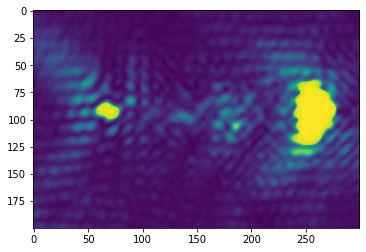

In [47]:
# test cell just to check alls well
im = Image.open(PATH+'kanamycin_videos_S2_jpg_crop/treated_resistant/video55/video0141.jpeg')
plt.imshow(im)